In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

In [2]:
from langchain_openai import OpenAIEmbeddings

import torch
from torch import nn
from functions import inference

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [4]:
def cosimilarity(p1, p2):
    embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")
    p1_emb = torch.tensor(embedding_model.embed_query(p1))
    p2_emb = torch.tensor(embedding_model.embed_query(p2))
    return torch.dot(p1_emb, p2_emb) / (torch.norm(p1_emb) * torch.norm(p2_emb))

#### 对比实验，将problem_set.json中所有题目和相似题两两求相似度，看这个相似度是的浮动范围

In [5]:
import json
with open("problem_set.json", 'r') as file:
    data = json.load(file)

In [6]:
problems = []
for ds in data:
    problems.append(ds['original_question'])
    problems.append(ds['similar_question_1'])
problems[:10]

['两个数相减的差是7.2。如果被减数增加8.6，减数减少2.7，则现在的差是多少？',
 '甲、乙两个人的体重差是15公斤。如果甲的体重增加12.5公斤，乙的体重减少4.8公斤，那么现在甲、乙两个人的体重差是多少？',
 '2022年参加北京冬奥会的总人数为2892人，比第一届夏蒙尼冬奥会的12倍少204人，参加第一届冬奥会人数是多少人？',
 '张先生买了5本书和3支笔，共花费56元。如果每本书的价格是每支笔的3倍，并且书的单价比笔贵8元，那么每本书和每支笔的价格分别是多少元？',
 '6161 × 39 - 3939 × 61',
 '计算 98×102 的值',
 '一个等腰三角形其中一个角的度数为50度，求另外两个角的度数。',
 '在一个三角形ABC中，已知角A为30度，角B为45度，且边AC的长度为10厘米。求边AB的长度。',
 '两个质数的和为39，这两个质数分别是多少？',
 '找出两个不同的质数 p 和 q，使得 p+q 是质数，并且 p×q 是合数。']

In [55]:
n = len(problems[:10])
htmap = [[0 for _ in range(n)] for _ in range(n)]

for i in range(n):
    for j in range(i, n):
        print(f"----calculating {i} and {j}----")
        htmap[i][j] = cosimilarity(problems[i], problems[j]).item()
htmap

----calculating 0 and 0----
----calculating 0 and 1----
----calculating 0 and 2----
----calculating 0 and 3----
----calculating 0 and 4----
----calculating 0 and 5----
----calculating 0 and 6----
----calculating 0 and 7----
----calculating 0 and 8----
----calculating 0 and 9----
----calculating 1 and 1----
----calculating 1 and 2----
----calculating 1 and 3----
----calculating 1 and 4----
----calculating 1 and 5----
----calculating 1 and 6----
----calculating 1 and 7----
----calculating 1 and 8----
----calculating 1 and 9----
----calculating 2 and 2----
----calculating 2 and 3----
----calculating 2 and 4----
----calculating 2 and 5----
----calculating 2 and 6----
----calculating 2 and 7----
----calculating 2 and 8----
----calculating 2 and 9----
----calculating 3 and 3----
----calculating 3 and 4----
----calculating 3 and 5----
----calculating 3 and 6----
----calculating 3 and 7----
----calculating 3 and 8----
----calculating 3 and 9----
----calculating 4 and 4----
----calculating 4 an

[[1.0000003576278687,
  0.4930083453655243,
  0.1816679984331131,
  0.2743418216705322,
  0.25486132502555847,
  0.2348862588405609,
  0.20026186108589172,
  0.21198856830596924,
  0.34354642033576965,
  0.24307794868946075],
 [0,
  0.9999996423721313,
  0.15886589884757996,
  0.293432354927063,
  0.22528862953186035,
  0.21695031225681305,
  0.22395560145378113,
  0.29290980100631714,
  0.28593963384628296,
  0.17245733737945557],
 [0,
  0,
  0.9999873638153076,
  0.05544416978955269,
  0.11034207791090012,
  0.15701983869075775,
  0.05702918395400047,
  0.030126644298434258,
  0.1309421807527542,
  0.08066099137067795],
 [0,
  0,
  0,
  0.9999988079071045,
  0.2103121131658554,
  0.1794530302286148,
  0.273135781288147,
  0.25059497356414795,
  0.25908732414245605,
  0.17544710636138916],
 [0,
  0,
  0,
  0,
  0.9999980330467224,
  0.26560619473457336,
  0.17370668053627014,
  0.12776802480220795,
  0.506051778793335,
  0.30795252323150635],
 [0,
  0,
  0,
  0,
  0,
  1.0000002384185

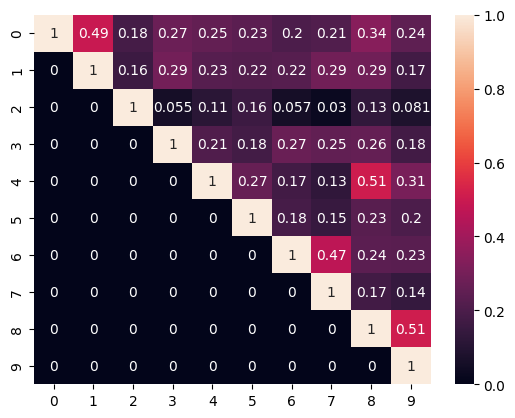

In [56]:
# importing the modules 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
    
# generating 2-D 10x10 matrix of random numbers 
# from 1 to 100 
data = np.array(htmap) 
    
# plotting the heatmap 
hm = sns.heatmap(data=data, 
                annot=True) 
    
# displaying the plotted heatmap 
plt.show()

#### 先用GPT抽取标签

In [10]:
extract_prompt = r"""
    请从以下数学题目中提取关键信息。请返回以下格式的信息：

    1. 数学领域和类型（如代数、几何、微积分、统计等）
    2. 核心概念和原理（列出题目所需要的数学概念，如比例、相似、函数性质等）
    3. 解题方法和策略（列出用到特定的解题技巧，如配方法、换元法、归纳法等）
    4. 问题背景和情境（指出题目问题情境，如工程问题、经济问题、自然现象解释）
    5. 变量数量（题目所用到变量的数量，一定不要输出变量具体是什么）
    6. 题目所属年级（列出这道题最可能出现在哪一年级的试卷上）

    示例题目：
    求解方程 2x + 3 = 7

    示例输出：
    1. 数学领域和类型: 代数
    2. 核心概念和原理: 方程
    3. 解题方法和策略: 移项
    4. 问题背景和情境: 无
    5. 变量数量: 1
    6. 题目所属年级: 4

    现在请处理以下题目：
    {problem}
"""

In [11]:
await inference({"problem": problems[1]}, extract_prompt)

executing
1. 数学领域和类型: 代数
2. 核心概念和原理: 差、加法、减法
3. 解题方法和策略: 直接计算
4. 问题背景和情境: 日常生活问题
5. 变量数量: 2
6. 题目所属年级: 5

'1. 数学领域和类型: 代数\n2. 核心概念和原理: 差、加法、减法\n3. 解题方法和策略: 直接计算\n4. 问题背景和情境: 日常生活问题\n5. 变量数量: 2\n6. 题目所属年级: 5'

In [13]:
import re

In [14]:
problem_mat = []
for p in problems[:10]:
    cur = []
    text = await inference({"problem":p}, extract_prompt)
    pattern = r'\d+\.\s.*?:\s*(.*)'
    matches = re.findall(pattern, text)
    for i, match in enumerate(matches, 1):
        cur.append(match)
    problem_mat.append(cur)

problem_mat

executing
1. 数学领域和类型: 代数
2. 核心概念和原理: 数的运算、差
3. 解题方法和策略: 直接计算
4. 问题背景和情境: 无
5. 变量数量: 2
6. 题目所属年级: 5executing
1. 数学领域和类型: 代数
2. 核心概念和原理: 差、加法、减法
3. 解题方法和策略: 直接计算
4. 问题背景和情境: 日常生活问题
5. 变量数量: 2
6. 题目所属年级: 5executing
1. 数学领域和类型: 代数
2. 核心概念和原理: 方程、比例
3. 解题方法和策略: 设未知数、列方程、解方程
4. 问题背景和情境: 体育赛事统计
5. 变量数量: 1
6. 题目所属年级: 5executing
1. 数学领域和类型: 代数
2. 核心概念和原理: 方程、比例
3. 解题方法和策略: 设未知数、列方程组、解方程
4. 问题背景和情境: 购物问题
5. 变量数量: 2
6. 题目所属年级: 7executing
1. 数学领域和类型: 算术
2. 核心概念和原理: 乘法、减法、分配律
3. 解题方法和策略: 分配律、简化计算
4. 问题背景和情境: 无
5. 变量数量: 0
6. 题目所属年级: 6executing
1. 数学领域和类型: 算术
2. 核心概念和原理: 乘法
3. 解题方法和策略: 拆分法（将数字拆分成易于计算的部分）
4. 问题背景和情境: 无
5. 变量数量: 0
6. 题目所属年级: 5executing
1. 数学领域和类型: 几何
2. 核心概念和原理: 三角形内角和、等腰三角形性质
3. 解题方法和策略: 角度计算
4. 问题背景和情境: 无
5. 变量数量: 2
6. 题目所属年级: 7executing
1. 数学领域和类型: 几何
2. 核心概念和原理: 三角形内角和、正弦定理
3. 解题方法和策略: 正弦定理
4. 问题背景和情境: 无
5. 变量数量: 3
6. 题目所属年级: 8executing
1. 数学领域和类型: 数论
2. 核心概念和原理: 质数
3. 解题方法和策略: 穷举法
4. 问题背景和情境: 无
5. 变量数量: 2
6. 题目所属年级: 6executing
1. 数学领域和类型: 数论
2. 核心概念和原理: 质数、合数
3. 解题方法和策略: 枚举法、质数判定


[['代数', '数的运算、差', '直接计算', '无', '2', '5'],
 ['代数', '差、加法、减法', '直接计算', '日常生活问题', '2', '5'],
 ['代数', '方程、比例', '设未知数、列方程、解方程', '体育赛事统计', '1', '5'],
 ['代数', '方程、比例', '设未知数、列方程组、解方程', '购物问题', '2', '7'],
 ['算术', '乘法、减法、分配律', '分配律、简化计算', '无', '0', '6'],
 ['算术', '乘法', '拆分法（将数字拆分成易于计算的部分）', '无', '0', '5'],
 ['几何', '三角形内角和、等腰三角形性质', '角度计算', '无', '2', '7'],
 ['几何', '三角形内角和、正弦定理', '正弦定理', '无', '3', '8'],
 ['数论', '质数', '穷举法', '无', '2', '6'],
 ['数论', '质数、合数', '枚举法、质数判定', '无', '2', '8']]

In [15]:
weights = [0.4, 0.2, 0.15, 0.05, 0.05, 0.15]

In [16]:
htmap2 = [[0 for _ in range(6)] for _ in range(6)]
for i in range(6):
    for j in range(i, 6):
        print(f"-----calculating {i} and {j}-----")
        tot_similarity = 0
        for k in range(6):
            tot_similarity += weights[k] * cosimilarity(problem_mat[i][k], problem_mat[j][k]).item()
        # avg_similarity = tot_similarity / 6
        htmap2[i][j] = tot_similarity

-----calculating 0 and 0-----
-----calculating 0 and 1-----
-----calculating 0 and 2-----
-----calculating 0 and 3-----
-----calculating 0 and 4-----
-----calculating 0 and 5-----
-----calculating 1 and 1-----
-----calculating 1 and 2-----
-----calculating 1 and 3-----
-----calculating 1 and 4-----
-----calculating 1 and 5-----
-----calculating 2 and 2-----
-----calculating 2 and 3-----
-----calculating 2 and 4-----
-----calculating 2 and 5-----
-----calculating 3 and 3-----
-----calculating 3 and 4-----
-----calculating 3 and 5-----
-----calculating 4 and 4-----
-----calculating 4 and 5-----
-----calculating 5 and 5-----


In [25]:
tmp = [[0 for _ in range(6)] for _ in range(6)]
for i in range(6):
    for j in range(6):
        tmp[i][j] = htmap2[i][j]


In [26]:
for i in range(6):
    for j in range(i):
        tmp[i][j] = tmp[j][i]

In [27]:
for i in range(6):
    tmp[i][i] = 0

In [34]:
import torch
import torch.nn.functional as F

logits = torch.tensor(tmp)
temperature = 0.5
prob = F.softmax(logits, dim=1)

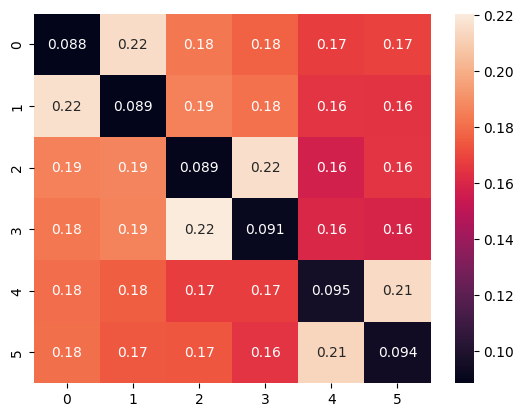

In [35]:
# importing the modules 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
    
# generating 2-D 10x10 matrix of random numbers 
# from 1 to 100 
data = np.array(prob) 
    
# plotting the heatmap 
hm = sns.heatmap(data=data, 
                annot=True) 
    
# displaying the plotted heatmap 
plt.show()